In [25]:
# Source: https://blog.socialcops.com/engineering/machine-learning-python/

# except you can't run tensorflow from the skflow method used in that article anymore.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, cross_validation, tree, preprocessing, metrics
import sklearn.ensemble as ske


/Users/cherny/miniconda3/envs/pandasnlp/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
titanic_df = pd.read_excel('titanic3.xls', 'titanic3', index_col=None, na_values=['NA'])

The column heading variables have the following meanings:

* survival: Survival (0 = no; 1 = yes)
* class: Passenger class (1 = first; 2 = second; 3 = third)
* name: Name
* sex: Sex
* age: Age
* sibsp: Number of siblings/spouses aboard
* parch: Number of parents/children aboard
* ticket: Ticket number
* fare: Passenger fare
* cabin: Cabin
* embarked: Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
* boat: Lifeboat (if survived)
* body: Body number (if did not survive and body was recovered)

In [3]:
# Chance of survival
titanic_df['survived'].mean()

0.3819709702062643

In [5]:
# by class - mean of these variables
titanic_df.groupby('pclass').mean()

,survived,age,sibsp,parch,fare,body
pclass,,,,,,
1,0.619195,39.159918,0.436533,0.365325,87.508992,162.828571
2,0.429603,29.506705,0.393502,0.368231,21.179196,167.387097
3,0.255289,24.816367,0.568406,0.400564,13.302889,155.818182


In [6]:
class_sex_grouping = titanic_df.groupby(['pclass','sex']).mean()
class_sex_grouping

survived        age     sibsp     parch        fare        body
pclass sex                                                                    
1      female  0.965278  37.037594  0.555556  0.472222  109.412385         NaN
       male    0.340782  41.029250  0.340782  0.279330   69.888385  162.828571
2      female  0.886792  27.499191  0.500000  0.650943   23.234827   52.000000
       male    0.146199  30.815401  0.327485  0.192982   19.904946  171.233333
3      female  0.490741  22.185307  0.791667  0.731481   15.324250  183.000000
       male    0.152130  25.962273  0.470588  0.255578   12.415462  151.854167

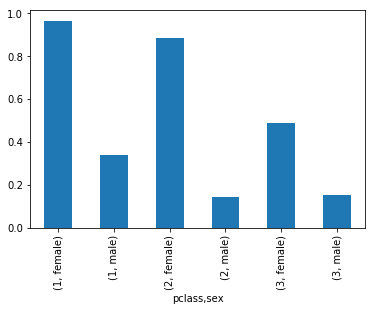

In [7]:
class_sex_grouping['survived'].plot.bar()

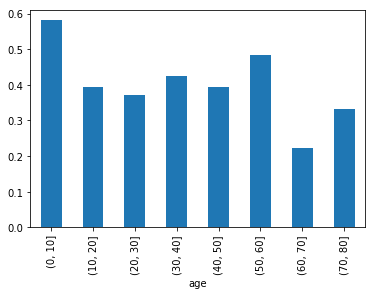

In [8]:
group_by_age = pd.cut(titanic_df["age"], np.arange(0, 90, 10))
age_grouping = titanic_df.groupby(group_by_age).mean()
age_grouping['survived'].plot.bar()

In [9]:
# count the values we have in the data columns
titanic_df.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

In [10]:
titanic_df = titanic_df.drop(['body','cabin','boat'], axis=1)
titanic_df["home.dest"] = titanic_df["home.dest"].fillna("NA")
titanic_df = titanic_df.dropna()
titanic_df.count()

pclass       1043
survived     1043
name         1043
sex          1043
age          1043
sibsp        1043
parch        1043
ticket       1043
fare         1043
embarked     1043
home.dest    1043
dtype: int64

In [11]:
def preprocess_titanic_df(df):
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    processed_df.sex = le.fit_transform(processed_df.sex)
    processed_df.embarked = le.fit_transform(processed_df.embarked)
    processed_df = processed_df.drop(['name','ticket','home.dest'],axis=1)
    return processed_df

In [12]:
processed_df = preprocess_titanic_df(titanic_df)

In [13]:
processed_df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,0,29.0000,0,0,211.3375,2
1,1,1,1,0.9167,1,2,151.5500,2
2,1,0,0,2.0000,1,2,151.5500,2
3,1,0,1,30.0000,1,2,151.5500,2
4,1,0,0,25.0000,1,2,151.5500,2


In [14]:
X = processed_df.drop(['survived'], axis=1).values
y = processed_df['survived'].values

In [15]:
labels = processed_df.drop(['survived'], axis=1).columns
labels

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked'], dtype='object')

In [16]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)

In [17]:
clf_dt = tree.DecisionTreeClassifier(max_depth=10)
clf_dt.fit(X_train, y_train)
clf_dt.score(X_test, y_test)

0.78947368421052633

## Make the Graphic Tree

In [18]:
tree.export_graphviz(clf_dt, out_file='tree.dot', feature_names=labels)     

In [19]:
# command line if you have dot installed
!dot -Tpng tree.dot -o tree.png

<img src="tree.png">

In [20]:
shuffle_validator = cross_validation.ShuffleSplit(len(X), n_iter=20, test_size=0.2, random_state=0)
def test_classifier(clf):
    scores = cross_validation.cross_val_score(clf, X, y, cv=shuffle_validator)
    print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))
    
test_classifier(clf_dt)

Accuracy: 0.7749 (+/- 0.02)


In [21]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
test_classifier(clf_rf)


clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
test_classifier(clf_gb)


eclf = ske.VotingClassifier([('dt', clf_dt), ('rf', clf_rf), ('gb', clf_gb)])
test_classifier(eclf)

Accuracy: 0.7804 (+/- 0.02)
Accuracy: 0.8201 (+/- 0.02)
Accuracy: 0.8029 (+/- 0.02)


At this point we deviate from the post because the interface to tensorflow no longer works as shown, and the results weren't great anyway. Let's look at the errors made by the decision tree in more detail.

In [22]:
clf_dt.score (X_test, y_test)


0.78947368421052633

In [23]:
passengers_set_1 = titanic_df[titanic_df.pclass == 1].iloc[:20,:].copy()
passengers_set_2 = titanic_df[titanic_df.pclass == 2].iloc[:20,:].copy()
passengers_set_3 = titanic_df[titanic_df.pclass == 3].iloc[:20,:].copy()
passenger_set = pd.concat([passengers_set_1,passengers_set_2,passengers_set_3])

In [24]:
testing_set = preprocess_titanic_df(passenger_set)
training_set = pd.concat([titanic_df, passenger_set]).drop_duplicates(keep=False)
training_set = preprocess_titanic_df(training_set)
X_train = training_set.drop(['survived'], axis=1).values
y_train = training_set['survived'].values
X_test = testing_set.drop(['survived'], axis=1).values
y_test = testing_set['survived'].values
clf_dt.fit (X_train, y_train)
clf_dt.score (X_test, y_test)

0.76666666666666672

In [25]:
# Looking at the people who did not match the prediction.  These are false negatives and false positives.

prediction = clf_dt.predict(X_test)
passenger_set[passenger_set.survived != prediction]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,home.dest
2,1,0,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0,0,0,19952,26.5500,S,"New York, NY"
14,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,S,"Hessle, Yorks"
16,1,0,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,C,"Montreal, PQ"
19,1,0,"Beattie, Mr. Thomson",male,36.0,0,0,13050,75.2417,C,"Winnipeg, MN"
20,1,1,"Beckwith, Mr. Richard Leonard",male,37.0,1,1,11751,52.5542,S,"New York, NY"
336,2,1,"Beane, Mr. Edward",male,32.0,1,0,2908,26.0000,S,"Norwich / New York, NY"
603,3,1,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,S,"East Providence, RI"
605,3,1,"Abelseth, Mr. Olaus Jorgensen",male,25.0,0,0,348122,7.6500,S,"Perkins County, SD"
